In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "/content/drive/MyDrive/AudioData.zip"

In [2]:
import librosa
import numpy as np

input_length = 16000*5

batch_size = 32

n_mels = 320

def preprocess_audio_mel_T(audio, sample_rate=16000, window_size=20, #log_specgram
                 step_size=10, eps=1e-10):

    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels= n_mels)
    mel_db = (librosa.power_to_db(mel_spec, ref=np.max) + 40)/40

    return mel_db.T


def load_audio_file(file_path, input_length=input_length):
  data = librosa.core.load(file_path, sr=16000)[0] #, sr=16000
  if len(data)>input_length:
    max_offset = len(data)-input_length
    
    offset = np.random.randint(max_offset)
    
    data = data[offset:(input_length+offset)]
            
  else:
    if input_length > len(data):
      max_offset = input_length - len(data)

      offset = np.random.randint(max_offset)
    else:
      offset = 0
    data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
    
  data = preprocess_audio_mel_T(data)
  return data

In [8]:
import os
from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt
import numpy as np

rootDirectory = "/content/AudioData/"
personNames = ["DC","JE","JK","KL"]

classes = ["a" , "d" , "f", "h", "n", "sa" , "su" ]

X = list()
y = list()

for person in personNames:
  directory = os.path.join(rootDirectory,person)
  for filename in os.listdir(directory):
    filePath = os.path.join(directory, filename)
    data = load_audio_file(file_path=filePath)
    data = np.reshape(data, data.shape + (1,))
    if(filename[0:1] in classes):
      X.append(data)
      y.append(classes.index(filename[0:1]))
    elif(filename[0:2] in classes):
      X.append(data)
      y.append(classes.index(filename[0:2]))

In [9]:
X = np.asarray(X, dtype=np.float32)
y = np.asarray(y, dtype=np.float32)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# dataset preparation

from tensorflow.keras import datasets,layers,models
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size= 0.7 ,random_state=10)

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(157,320,1)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64,(3,3),activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 155, 318, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 77, 159, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 157, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 78, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 76, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 170240)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [12]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

history = model.fit(X_train,y_train,epochs=30,validation_data=(X_test,y_test))

Epoch 1/30
11/11 [==============================] - 28s 2s/step - loss: 3.1605 - accuracy: 0.1845 - val_loss: 2.2921 - val_accuracy: 0.1528
Epoch 2/30
11/11 [==============================] - 26s 2s/step - loss: 2.0202 - accuracy: 0.2708 - val_loss: 2.1275 - val_accuracy: 0.1528
Epoch 3/30
11/11 [==============================] - 26s 2s/step - loss: 1.8117 - accuracy: 0.3036 - val_loss: 1.9424 - val_accuracy: 0.2431
Epoch 4/30
11/11 [==============================] - 26s 2s/step - loss: 1.4582 - accuracy: 0.4673 - val_loss: 1.9249 - val_accuracy: 0.2500
Epoch 5/30
11/11 [==============================] - 26s 2s/step - loss: 1.1255 - accuracy: 0.5833 - val_loss: 1.8715 - val_accuracy: 0.3194
Epoch 6/30
11/11 [==============================] - 26s 2s/step - loss: 0.7514 - accuracy: 0.7411 - val_loss: 1.9895 - val_accuracy: 0.3542
Epoch 7/30
11/11 [==============================] - 26s 2s/step - loss: 0.4764 - accuracy: 0.8333 - val_loss: 2.2782 - val_accuracy: 0.2986
Epoch 8/30
11/11 [==

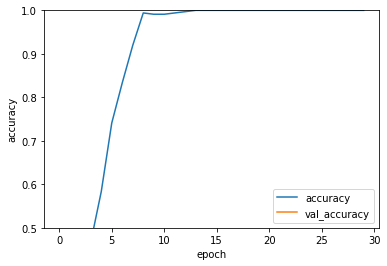

In [13]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.5,1])
plt.legend(loc='lower right')

plt.show()

In [14]:
test_loss , test_acc = model.evaluate(X_test,y_test,verbose=2)

5/5 - 3s - loss: 5.4739 - accuracy: 0.3125
